# How to use prior knowledge in RESIT

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.2.3', '0.20.3', '1.10.0']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')
    
    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

## Test data
First, we generate a causal structure with 7 variables. Then we create a dataset with 6 variables from x0 to x5, with x6 being the latent variable for x2 and x3.

In [3]:
X = pd.read_csv('nonlinear_data.csv')

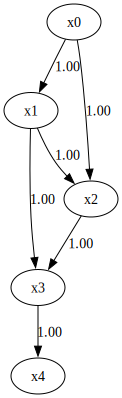

In [4]:
m = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0]])

dot = make_dot(m)

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Make Prior Knowledge Matrix
We create prior knowledge so that x0 and x4 are sink variables.

The elements of prior knowledge matrix are defined as follows:
* ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
* ``1`` : :math:`x_i` has a directed path to :math:`x_j`
* ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [5]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    sink_variables=[0, 4]
)
print(prior_knowledge)

[[-1 -1 -1 -1  0]
 [ 0 -1 -1 -1  0]
 [ 0 -1 -1 -1  0]
 [ 0 -1 -1 -1  0]
 [ 0 -1 -1 -1 -1]]


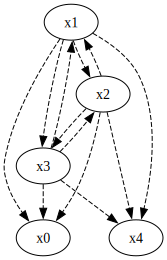

In [6]:
# Draw a graph of prior knowledge
make_prior_knowledge_graph(prior_knowledge)

## Causal Discovery
To run causal discovery using prior knowledge, we create a `RESIT` object with the prior knowledge matrix.

In [7]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=4, random_state=0)

model = lingam.RESIT(regressor=reg, prior_knowledge=prior_knowledge)
model.fit(X)
print(model.causal_order_)
print(model.adjacency_matrix_)

[1, 2, 3, 0, 4]
[[0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


We can see that x0 and x4 are output as sink variables, as specified in the prior knowledge.

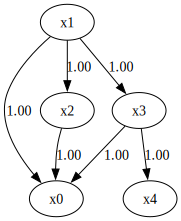

In [8]:
make_dot(model.adjacency_matrix_)

Next, let's specify the prior knowledge so that x2 is an exogenous variable.

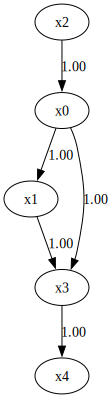

In [9]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    exogenous_variables=[2],
)

model = lingam.RESIT(regressor=reg, prior_knowledge=prior_knowledge)
model.fit(X)

make_dot(model.adjacency_matrix_)